This notebook was obtained from the following Kaggle link:
https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

I changed the way that the training and test databases are built because the original code was causing Index errors.  I modified the indexing method by concating or slicing the strings in the path and id columns.  The actual tables in the training and test datasets remain unchanged, only the method for building those tables was altered.

Due to the sheer size of the cancer input data provided, the original program took hours to complete.  In order to run the algorithm in a reasonable amount of time, I lowered the sample size of the training and test models.  The following is a list of changes I made:

The sample size of the training set lowered from SAMPLE_SIZE = 80000 to SAMPLE_SIZE = 800  
The model's number of epochs lowered from epochs=13 to epochs=5  
The maxium test images lowered from max_idx = len(test_files) to max_idx = 25000  

Since I didn't test every image in the test folder, my final submission file has the incorrect number of indexes to be submitted on Kaggle.  Because my submission could not be evaluated by Kaggle, I submitted the csv output provided by the original author.  Below is a screenshot of the leaderboard score evaluated from the author's submission:

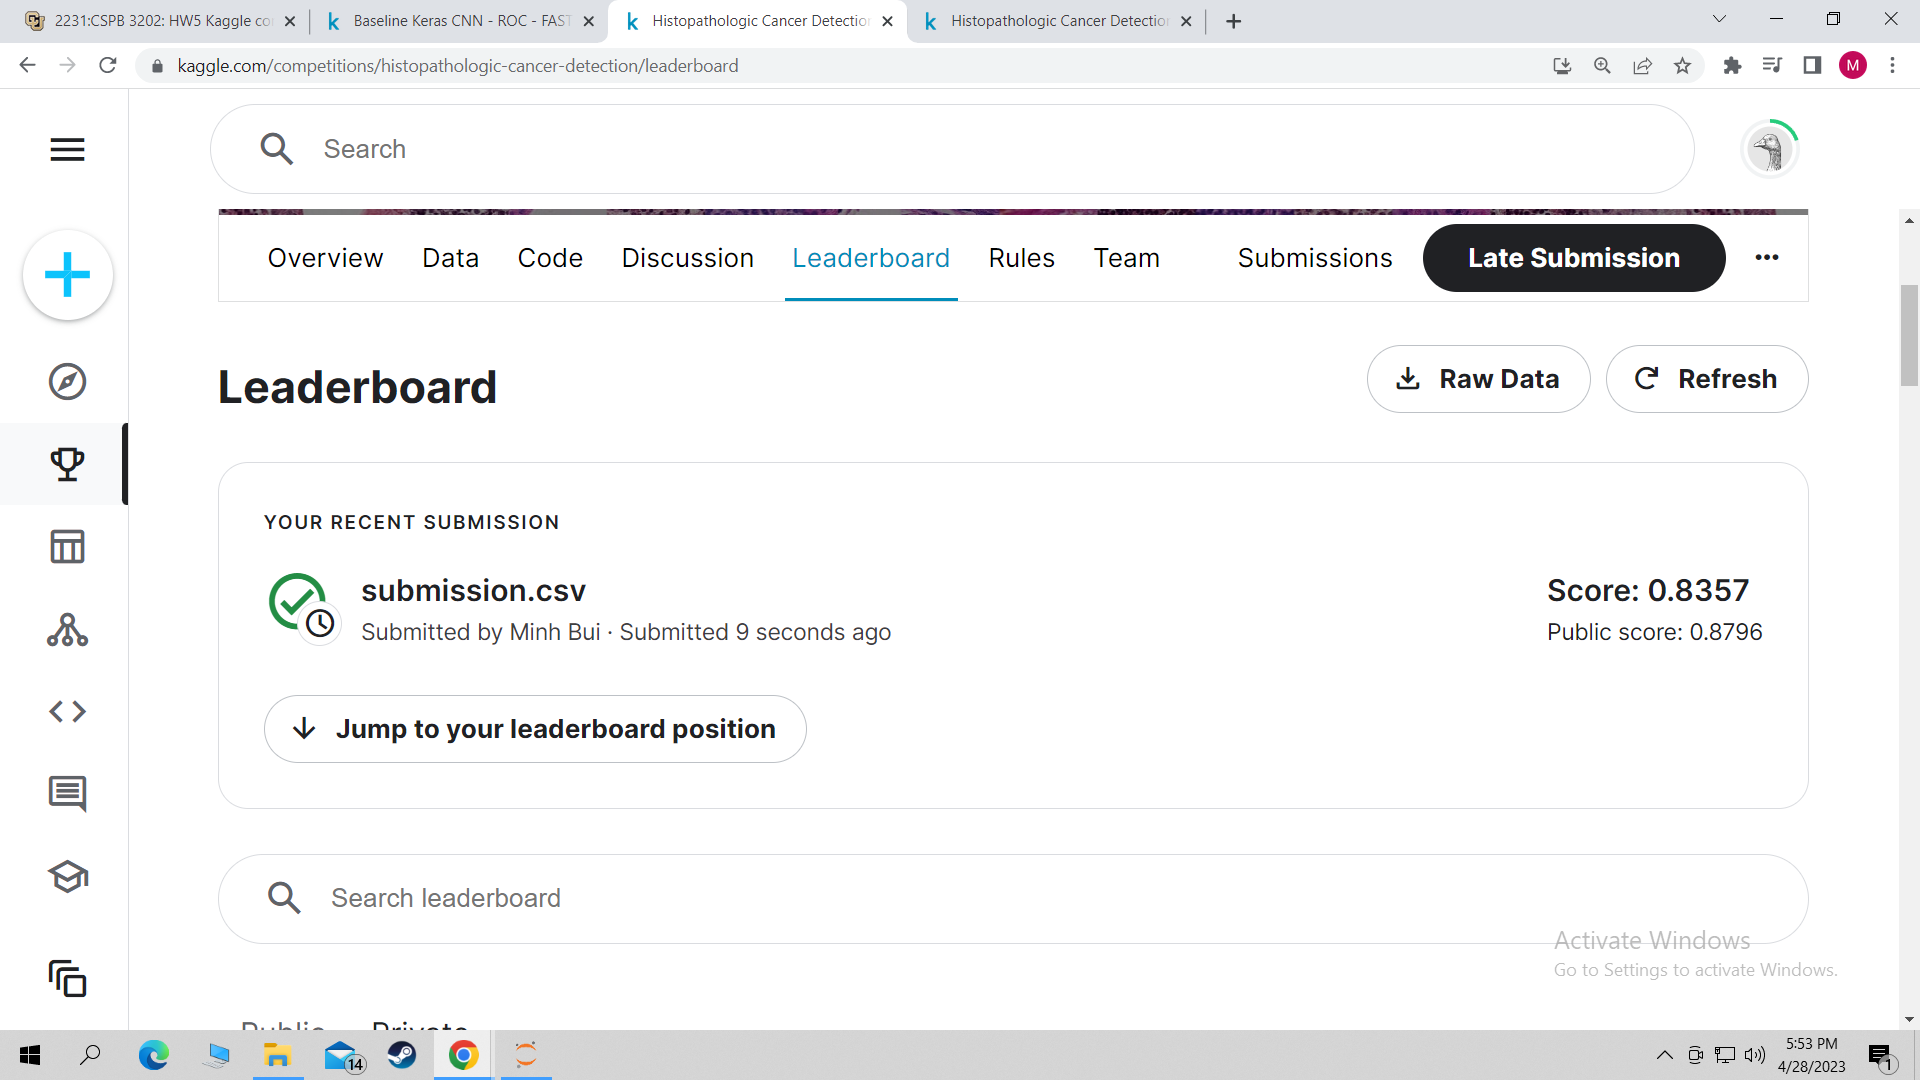

My GitHub repo containing this Python Notebook, CSV submission, and leaderboard image is linked here: 
https://github.com/Minh-Thien-Bui/Histopathologic-Cancer-Detection.git

# Baseline Keras CNN with 160k samples
Heavily inspired by https://www.kaggle.com/hrmello/cnn-classification-80-accuracy

Thanks to @Marsh for https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

In [206]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil
print(os.listdir("../input"))

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

['baseline-keras-cnn-roc-fast-10min-0-925-lb.ipynb', 'sample_submission.csv', 'test', 'train', 'train_labels.csv']


# Load data

In [207]:
#set paths to training and test data
path = "../input/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'

df_data = pd.read_csv(path + "train_labels.csv")
df_data.insert(
    loc = 0,
    column = 'path',
    value = train_path + df_data['id'] + '.tif'
)

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
df_data.head(3)

,path,id,label
0,../input/train/f38a6374c348f90b587e046aac60799...,f38a6374c348f90b587e046aac6079959adf3835,0
1,../input/train/c18f2d887b7ae4f6742ee445113fa1a...,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,../input/train/755db6279dae599ebb4d39a9123cce4...,755db6279dae599ebb4d39a9123cce439965282d,0


# Split X and y in train/test and build folders

In [208]:
SAMPLE_SIZE = 800 # load 800 negative examples

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

# Create directories
train_path = 'base_dir/train'
valid_path = 'base_dir/valid'
test_path = '../input/test'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        try:
            os.makedirs(os.path.join(fold, subf))
        except:
            pass

In [209]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
df_data.head()

,path,label
id,,
8847d20c014f065c01354ab8b24ace292dd5e45d,../input/train/8847d20c014f065c01354ab8b24ace2...,1
33761d25e0de499530db1989506a2640efec3bd9,../input/train/33761d25e0de499530db1989506a264...,1
93e17eb84ee650d1100ae09cfd191460bb24ae5c,../input/train/93e17eb84ee650d1100ae09cfd19146...,1
8cd97aca62c41f75ecab8ba5c4ace5971445947a,../input/train/8cd97aca62c41f75ecab8ba5c4ace59...,1
36c791f3ed2da1c86ebaa278bd092cccb925f0f5,../input/train/36c791f3ed2da1c86ebaa278bd092cc...,1


In [210]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/train', fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/train', fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)


In [211]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 1440 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


# Define the model 
**Model structure (optimizer: Adam):**

* In 
* [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 16, 32, 64)
* Flatten 
* Dense (256) 
* Dropout 
* Out

In [212]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

# Train

In [213]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[reducel, earlystopper])

C:\Users\sephi\AppData\Local\Temp/ipykernel_6424/453260408.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


Epoch 1/5
45/45 [==============================] - 78s 2s/step - loss: 0.6836 - accuracy: 0.6764 - val_loss: 107.6793 - val_accuracy: 0.4938 - lr: 0.0100
Epoch 2/5
45/45 [==============================] - 72s 2s/step - loss: 0.5288 - accuracy: 0.7590 - val_loss: 33.9013 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/5
45/45 [==============================] - 71s 2s/step - loss: 0.5054 - accuracy: 0.7667 - val_loss: 4.9413 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/5
45/45 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.7674
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
45/45 [==============================] - 71s 2s/step - loss: 0.5003 - accuracy: 0.7674 - val_loss: 5.3764 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 5/5
45/45 [==============================] - 72s 2s/step - loss: 0.4581 - accuracy: 0.8035 - val_loss: 1.6995 - val_accuracy: 0.5562 - lr: 1.0000e-03


In [214]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

C:\Users\sephi\AppData\Local\Temp/ipykernel_6424/2876623563.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


160/160 [==============================] - 4s 21ms/step


0.6096875

# Plot ROC Curve

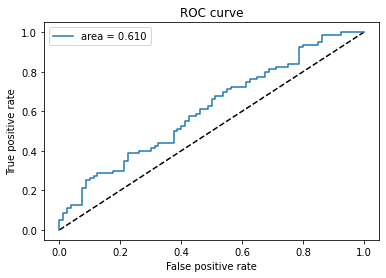

In [215]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Load test data and predict
I could not find a smart way to do this without crashing the Kernel (due to MemoryError). So I just load the test files in batches, predict, and concatenate the results.

In [216]:
base_test_dir = '../input/test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = 25000 #len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.str[14:-4]
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

Indexes: 0 - 5000
157/157 [==============================] - 55s 350ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 53s 340ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 53s 339ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 55s 348ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 55s 349ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.108153
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.824159
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.003250
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.001139
4,000270442cc15af719583a8172c87cd2bd9c7746,0.001830


In [217]:
#submission
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

try:
    shutil.rmtree(train_path)
except:
    pass

try:
    shutil.rmtree(valid_path)
except:
    pass

submission.to_csv("submission.csv", index = False, header = True)

In [218]:
pd.read_csv("submission.csv")

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.108153
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.824159
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.003250
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.001139
4,000270442cc15af719583a8172c87cd2bd9c7746,0.001830
...,...,...
24995,6eee2982e283cfd157a624bc8acaab740b789665,0.028559
24996,6eee33de7c196160c4ddd9d83ec84e16f2ae5e4d,0.623924
24997,6eee821154c44b58a3dc65bc4a2b14db317821d7,0.880253
24998,6eeea21e6c959cd669e59a0554809bb934505892,0.838949
